## 2. Тест Вензингера

In [64]:
import pandas as pd
import numpy
from matplotlib import pyplot as plt
from scipy import integrate, linalg

MainFoil = pd.read_csv('lessons/resources/NACA23012_MainFoil.csv')

MainFoil_x = MainFoil['1.000000000000000000e+00'].to_numpy(copy=True)
MainFoil_y = MainFoil['0.000000000000000000e+00'].to_numpy(copy=True)

MainFoil_x = numpy.insert(MainFoil_x, 0, 1.0)
MainFoil_y = numpy.insert(MainFoil_y, 0, 0.0)

In [65]:
FlapFoil = pd.read_csv('lessons/resources/NACA23012_FlapFoil.csv')

FlapFoil_x = FlapFoil['1.181999999999999940e+00'].to_numpy(copy=True)
FlapFoil_y = FlapFoil['-3.400000000000000244e-02'].to_numpy(copy=True)

FlapFoil_x = numpy.insert(FlapFoil_x, 0, 1.181999999999999940e+00)
FlapFoil_y = numpy.insert(FlapFoil_y, 0, -3.400000000000000244e-02)

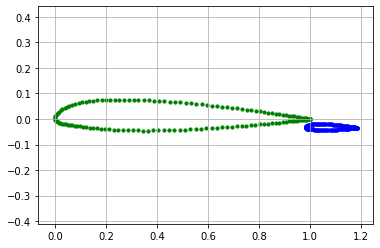

In [66]:
plt.scatter(MainFoil_x, MainFoil_y, color='g', s=10)
plt.scatter(FlapFoil_x, FlapFoil_y, color='b', s=10)
plt.axis("equal")
plt.grid()

## Классы и функции

In [67]:
class Panel:

    def __init__(self, xa, ya, xb, yb):

        self.xa, self.ya = xa, ya # начальная точка панели
        self.xb, self.yb = xb, yb # конечная точка панели
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # центр панели
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # длина панели
        
        # ориентация панели (угол между нормалью и осью x)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # расположение панели
        if self.beta <= numpy.pi:
            self.loc = 'upper' # верхняя поверхность
        else:
            self.loc = 'lower' # нижняя поверхность
        
        self.sigma = 0.0 # интенсивность источника
        self.vt = 0.0    # касательная скорость
        self.cp = 0.0    # коэффициент давления

In [68]:
def define_panels(x, y):

    panels = numpy.empty(len(x)-1, dtype=object)
    for i in range(len(x)-1):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    
    return panels

In [69]:
class Freestream:

    def __init__(self, u_inf=1.0, alpha=0.0):

        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # градусы в радианы

In [70]:
def integral(x, y, panel, dxdk, dydk):

    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [71]:
def source_contribution_normal(panels):

    A = numpy.empty((panels.size, panels.size), dtype=float)

    numpy.fill_diagonal(A, 0.5)

    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

In [72]:
def vortex_contribution_normal(panels):

    A = numpy.empty((panels.size, panels.size), dtype=float)

    numpy.fill_diagonal(A, 0.0)

    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [73]:
def kutta_condition(A_source, B_vortex, Na):

    b2 = numpy.empty(A_source.shape[0]+2, dtype=float)
    b1 = numpy.empty(A_source.shape[0]+2, dtype=float)
    
    b1[:-2] = B_vortex[0, :] + B_vortex[Na-1, :]
    b1[-2] = - numpy.sum(A_source[0, :Na] + A_source[Na-1, :Na])
    b1[-1] = - numpy.sum(A_source[0, Na:] + A_source[Na-1, Na:])
    
    b2[:-2] = B_vortex[Na, :] + B_vortex[-1, :]
    b2[-2] = - numpy.sum(A_source[Na, :Na] + A_source[-1, :Na])
    b2[-1] = - numpy.sum(A_source[Na, Na:] + A_source[-1, Na:])

    return b1, b2

In [74]:
def build_singularity_matrix(A_source, B_vortex, Na):

    A = numpy.empty((A_source.shape[0]+2, A_source.shape[1]+2), \
                    dtype=float)

    A[:-2, :-2] = A_source

    A[:-2, -2] = numpy.sum(B_vortex[:,0:Na], axis=1)
    A[:-2, -1] = numpy.sum(B_vortex[:,Na:], axis=1)
    
    A[-2, :], A[-1, :] = kutta_condition(A_source, B_vortex, numpy.size(MainFoil_panels))
    return A

In [75]:
def build_freestream_rhs(panels, freestream, Na):

    b = numpy.empty(panels.size+2,dtype=float)

    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)

        b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[Na-1].beta) )
        b[-2] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[Na].beta)
                               +numpy.sin(freestream.alpha-panels[-1].beta) )
    return b

In [157]:
def rotate_panels(centre, points_x, points_y, alpha):
    
    global MainFoil_panels
    
    alpha = alpha*numpy.pi/180.0
    points_new_x = numpy.zeros_like(points_x)
    points_new_y = points_new_x.copy()
    
    for i in range(numpy.size(points_x)):
        points_new_x[i] = (points_x[i] - centre[0])*numpy.cos(alpha) + \
        (points_y[i] - centre[1])*numpy.sin(alpha) + centre[0]
        points_new_y[i] = -(points_x[i] - centre[0])*numpy.sin(alpha) + \
        (points_y[i] - centre[1])*numpy.cos(alpha) + centre[1]
        
    points_new_x = numpy.append(points_new_x, points_new_x[0])
    points_new_y = numpy.append(points_new_y, points_new_y[0])
    
    FlapFoil_panels = define_panels(points_new_x, points_new_y)
    
    return numpy.concatenate((MainFoil_panels, FlapFoil_panels))

In [144]:
def compute_tangential_velocity(panels, freestream, gamma1, gamma2, A_source, B_vortex, Na):

    A = numpy.empty((panels.size, panels.size+2), dtype=float)
    # матрица вкладов источников в тангенциальную составляющую скорости
    # равна
    # матрице вкладов вихрей в нормальную составляющую скорости
    A[:, :-2] = B_vortex
    # матрица вкладов вихрей в тангенциальную составляющую скорости
    # противоположна по знаку
    # матрице вкладов источников в нормальную составляющую скорости
    A[:, -2] = -numpy.sum(A_source[:, :Na], axis=1)
    A[:, -1] = -numpy.sum(A_source[:, Na:], axis=1)
    # добавляем набегающий поток
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], [gamma1, gamma2])
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [145]:
def compute_pressure_coefficient(panels, freestream):

    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [146]:
def compute_L(panels, alpha, theta, Na):
    global gamma1
    global gamma2
    
    L = 0.
    D = 0.
    alpha = alpha*numpy.pi/180.0
    theta = theta*numpy.pi/180.0
    
    for i , panel in enumerate(panels):
        if i < Na:
            L += gamma1*panel.length
        else:
            L += gamma2*panel.length
        D += panel.cp * (panel.xb - panel.xa)
                
    chord_m = abs(max(panel.xa for panel in panels[:Na]) - min(panel.xa for panel in panels[:Na]))
    chord_fl = abs(max(panel.xa for panel in panels[Na:]) - min(panel.xa for panel in panels[Na:]))#/numpy.cos(alpha)
    
    L = -numpy.sin(theta)*D + numpy.cos(theta)*L
    
    return L/(chord_fl + chord_m)

In [147]:
def calculate_everything(panels, alpha, theta):
    
    global gamma1
    global gamma2
    
    u_inf = 1.0
    freestream = Freestream(u_inf, theta)
    
    global A_source
    global B_vortex
    global A

    b = build_freestream_rhs(panels, freestream, Na)
    
    strengths = numpy.linalg.solve(A, b)
    
    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]
        
    gamma1 = strengths[-2]
    gamma2 = strengths[-1]
    
    compute_tangential_velocity(panels, freestream, gamma1, gamma2, \
                                A_source, B_vortex, Na)

    compute_pressure_coefficient(panels, freestream)
    L = compute_L(panels, alpha, theta, Na)
    
    return L

## Собственно задача

(-0.3, 0.3)

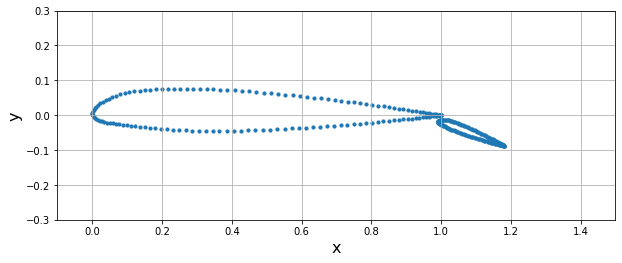

In [159]:
MainFoil_panels = define_panels(MainFoil_x, MainFoil_y)
FlapFoil_panels = define_panels(FlapFoil_x, FlapFoil_y)

Na = numpy.size(MainFoil_panels)
alpha = +20

panels_old = numpy.concatenate((MainFoil_panels, FlapFoil_panels))

rotating_point = [1.03, -0.054]
panels = rotate_panels(rotating_point, [panel.xa for panel in panels_old[Na:]], [panel.ya for panel in panels_old[Na:]], alpha)

width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.scatter(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            s=10)
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.5)
plt.ylim(-0.3, 0.3)

In [149]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(A_source, B_vortex, Na)

### Вопрос 1:

In [168]:
eps = 0.005

gamma1, gamma2 = 0., 0.

theta_right = 14
theta_left = -14

L_left = calculate_everything(panels, alpha, theta_left)
L_right = calculate_everything(panels, alpha, theta_right)

if (L_left*L_right > 0):
    print("Ну искать тут нечего:)")
    
print("%.3f" % L_left, "%.3f" % L_right)

-0.459 0.655


In [169]:
while(True):
    
    theta_mid = (theta_left + theta_right)/2
    L_mid = calculate_everything(panels, alpha, theta_mid)
    
    if (L_mid*L_left < 0):
        theta_right = theta_mid
    else:
        theta_left = theta_mid
        
    print("L =", "%.3f" % L_mid, "AoA =", theta_mid)
    
    if (abs(L_left - L_mid) < eps) or (abs(L_mid) < eps):
        break
        
print("Optimal AoA was found:", theta_mid)

L = 0.507 AoA = 0.0
L = 0.117 AoA = -7.0
L = -0.151 AoA = -10.5
L = -0.011 AoA = -8.75
L = 0.054 AoA = -7.875
L = 0.022 AoA = -8.3125
L = 0.005 AoA = -8.53125
L = -0.003 AoA = -8.640625
Optimal AoA was found: -8.640625


### Вопрос 2:

In [170]:
# theta = AoA, alpha = flap angle
eps = 0.005
theta = 0
rotating_point = [1.03, -0.054]

alpha_right = 20
alpha_left = -20

panels = rotate_panels(rotating_point, [panel.xa for panel in panels_old[Na:]], [panel.ya for panel in panels_old[Na:]], alpha_left)
L_left = calculate_everything(panels, alpha_left, theta)

panels = rotate_panels(rotating_point, [panel.xa for panel in panels_old[Na:]], [panel.ya for panel in panels_old[Na:]], alpha_right)
L_right = calculate_everything(panels, alpha_right, theta)

if (L_left*L_right > 0):
    print("Ну искать тут нечего:)")
    
print("%.3f" % L_left, "%.3f" % L_right)

-0.466 0.643


In [171]:
while(True):
    
    alpha_mid = (alpha_left + alpha_right)/2
    panels = rotate_panels(rotating_point, [panel.xa for panel in panels_old[Na:]], [panel.ya for panel in panels_old[Na:]], alpha_mid)
    
    L_mid = calculate_everything(panels, alpha_mid, theta)
    
    if (L_mid*L_left < 0):
        alpha_right = alpha_mid
    else:
        alpha_left = alpha_mid
        
    print("L =", "%.3f" % L_mid, "flap angle =", alpha_mid)
    
    if (abs(L_left - L_mid) < eps) or (abs(L_mid) < eps):
        break
        
print("Zero lift flap angle was found:", alpha_mid)

L = 0.091 flap angle = 0.0
L = -0.189 flap angle = -10.0
L = -0.049 flap angle = -5.0
L = 0.021 flap angle = -2.5
L = -0.014 flap angle = -3.75
L = 0.003 flap angle = -3.125
Zero lift flap angle was found: -3.125


### Вопрос 3:

In [172]:
theta = 4

alpha = 0
Lift0 = calculate_everything(panels_old, alpha, theta)
print("L =", "%.3f" % Lift0, "flap angle =", alpha, "\n")

alpha = 5
panels = rotate_panels(rotating_point, [panel.xa for panel in panels_old[Na:]], [panel.ya for panel in panels_old[Na:]], alpha)
Lift = calculate_everything(panels, alpha, theta)
print("L =", "%.3f" % Lift, "flap angle =", alpha)
print("Скорость упала на", "%.3f" % (100*(1 - (Lift0/Lift)**(1/2))), "%\n")

alpha = 10
panels = rotate_panels(rotating_point, [panel.xa for panel in panels_old[Na:]], [panel.ya for panel in panels_old[Na:]], alpha)
Lift = calculate_everything(panels, alpha, theta)
print("L =", "%.3f" % Lift, "flap angle =", alpha)
print("Скорость упала на", "%.3f" % (100*(1 - (Lift0/Lift)**(1/2))), "%\n")

alpha = 15
panels = rotate_panels(rotating_point, [panel.xa for panel in panels_old[Na:]], [panel.ya for panel in panels_old[Na:]], alpha)
Lift = calculate_everything(panels, alpha, theta)
print("L =","%.3f" % Lift, "flap angle =", alpha)
print("Скорость упала на", "%.3f" % (100*(1 - (Lift0/Lift)**(1/2))), "%\n")

L = 0.282 flap angle = 0 

L = 0.401 flap angle = 5
Скорость упала на 16.156 %

L = 0.519 flap angle = 10
Скорость упала на 26.297 %

L = 0.636 flap angle = 15
Скорость упала на 33.389 %

